# SUOX: Sulfite Oxidase Deficiency

[Sulfite oxidase deficiency (ISOD)](https://omim.org/entry/272300) is caused by homozygous or compound heterozygous mutation in the sulfite oxidase gene (SUOX).

Data from [Li JT, et al. Mutation analysis of SUOX in isolated sulfite oxidase deficiency with ectopia lentis as the presenting feature: insights into genotype-phenotype correlation](https://pubmed.ncbi.nlm.nih.gov/36303223/)

In [1]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2023-10-09')
print(f'Loaded HPO v{hpo.version}')
print(f"Using genophenocorr version {gpsea.__version__}")

Loaded HPO v2023-10-09
Using genophenocorr version 0.9.1.dev0


### SUOX
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for SUOX.

In [2]:
gene_symbol = 'NKX6-2'
mane_tx_id = 'NM_001032386.2' 
mane_protein_id = 'NP_001027558.1' # sulfite oxidase, mitochondrial

In [3]:
from ppktstore.registry import configure_phenopacket_registry
phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store("0.1.22") as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))
print(f'Loaded {len(phenopackets)} phenopackets')

from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets, load_phenopacket_folder
cohort_creator = configure_caching_cohort_creator(hpo)

"""
cohort, validation = load_phenopackets(  
    phenopackets=phenopackets,
    cohort_creator=cohort_creator,
)
"""
ppkt = "../../../phenopacket-store/notebooks/SUOX/phenopackets"
cohort, validation = load_phenopacket_folder(  
    #phenopackets=phenopackets,
    pp_directory=ppkt,
    cohort_creator=cohort_creator,
)
validation.summarize()

Loaded 33 phenopackets
Individuals Processed: 35individuals [01:31,  2.60s/individuals]
Validated under permissive policy
No errors or warnings were found


In [4]:
from gpsea.view import CohortViewer

viewer = CohortViewer(hpo)
viewer.process(cohort=cohort, transcript_id=mane_tx_id)

n,HPO Term
28,Seizure
15,Hypotonia
13,Sulfocysteinuria
11,Hypertonia
11,Abnormality of extrapyramidal motor function
10,Microcephaly
10,Hypohomocysteinemia
8,Neurodevelopmental delay
7,Hypocystinemia
7,Ectopia lentis


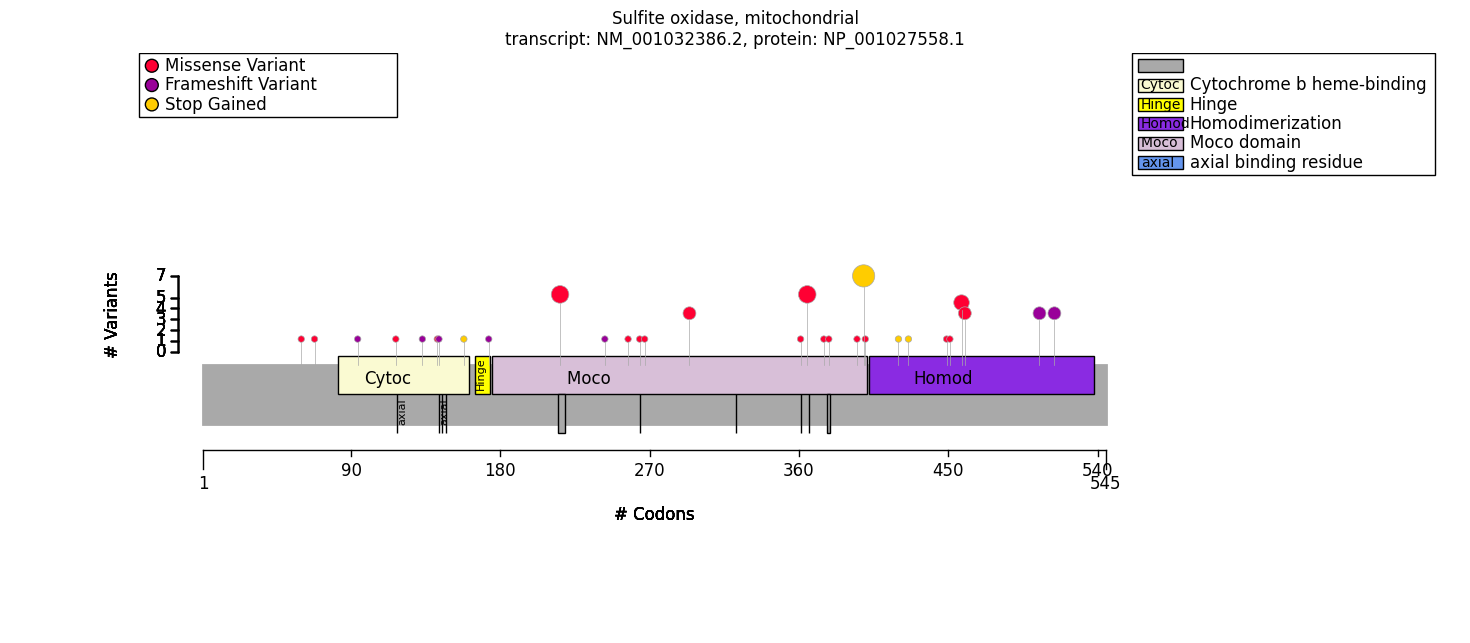

In [5]:
from gpsea.model.genome import GRCh38
from gpsea.model import ProteinMetadata
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)

suox_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
suox_fig.tight_layout()

In [6]:
from gpsea.view import ProteinVariantViewer
viewer = ProteinVariantViewer(protein_meta, mane_tx_id)
html_prot = viewer.process(cohort)
html_prot

Count,Name,Type,Coordinates,Variants
6,Cytochrome b5 heme-binding,Domain,83 - 161,p.Gln145SerfsTer16; p.His118Tyr; p.Glu134ProfsTer26; p.His143Asn; p.Glu97Ter; p.Glu159Ter
0,axial binding residue,Binding site,119 - 118,
0,axial binding residue,Binding site,144 - 143,
0,,Binding site,146 - 145,
0,,Binding site,148 - 147,
1,Hinge,Region,166 - 174,p.Asp174ThrfsTer13
26,Moco domain,Region,176 - 401,p.Arg217Gly; p.Gln396Arg; p.Arg366Cys; p.Gly362Ser; p.Arg366His; p.Gly295Glu; p.Lys379Arg; p.Tyr400Ter; p.Leu245ProfsTer27; p.Arg376Cys; p.Ala265Asp; p.Arg268Gln; p.Lys401Glu; p.Ile258Leu; p.Arg217Gln
4,,Binding site,216 - 219,p.Arg217Gly; p.Arg217Gln
0,,Binding site,265 - 264,
0,,Binding site,323 - 322,


In [7]:
from gpsea.view import CohortVariantViewer
cvv = CohortVariantViewer(tx_id=mane_tx_id)
cvv.process(cohort=cohort)

Count,Variant key,HGVS,Overlapping Exons,Effects
7,12_56004589_56004589_C_G,c.1200C>G (p.Tyr400Ter),5,stop gained
3,12_56004039_56004039_G_A,c.650G>A (p.Arg217Gln),5,missense
3,12_56004765_56004765_G_A,c.1376G>A (p.Arg459Gln),5,missense
3,12_56004485_56004485_C_T,c.1096C>T (p.Arg366Cys),5,missense
2,12_56004771_56004771_A_T,c.1382A>T (p.Asp461Val),5,missense
2,12_56004933_56004933_A_ACAATGTGCAGCCAGACACCGTGGCCC,c.1549_1574dup (p.Ile525MetfsTer102),5,frameshift
2,12_56004905_56004909_ATTGT_A,c.1521_1524del (p.Cys508ArgfsTer109),5,frameshift
2,12_56004273_56004273_G_A,c.884G>A (p.Gly295Glu),5,missense
1,12_56003788_56003792_AGAGC_A,c.400_403del (p.Glu134ProfsTer26),5,frameshift
1,12_56003820_56003821_AC_A,c.433del (p.Gln145SerfsTer16),5,frameshift


# Genotype-Phenotype Correlation (GPC) Analysis

In [8]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
analysis = configure_hpo_term_analysis(hpo)

from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest
pheno_predicates = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [9]:
from gpsea.analysis.predicate import variant_effect
from gpsea.analysis.clf import biallelic_classifier
from gpsea.model import VariantEffect
from gpsea.view import MtcStatsViewer

missense = variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)

missense_predicate = biallelic_classifier(
    a_predicate=missense,
    b_predicate=~missense,
    a_label="Missense",
    b_label="Other",
    partitions=((0,1), (2,))
)

missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=missense_predicate,
    pheno_clfs=pheno_predicates,
)


viewer = MtcStatsViewer()
viewer.process(missense_result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,3
HMF03,Skipping term because of a child term with the same individual counts,1
HMF08,Skipping general term,26
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,25


In [10]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=missense_result)

Allele group                                       Missense/Missense OR Missense/Other  \
                                                                                 Count   
Seizure [HP:0001250]                                                             17/24   
Hypotonia [HP:0001252]                                                           12/16   
Abnormality of extrapyramidal motor function [H...                                9/17   
Neurodevelopmental delay [HP:0012758]                                             4/17   
Microcephaly [HP:0000252]                                                         6/14   
Hypertonia [HP:0001276]                                                           7/16   
Abnormal muscle tone [HP:0003808]                                                14/14   
Abnormal circulating sulfur amino acid concentr...                               10/10   
Abnormal circulating amino acid concentration [...                               10/10   
Neurodevelopmental abnormality [HP:0012759]                                      10/10   
Ectopia lentis [HP:0001083]                                                       6/15   

Allele group                                               Other/Other  \
                                                   Percent       Count   
Seizure [HP:0001250]                                   71%       11/11   
Hypotonia [HP:0001252]                                 75%         3/7   
Abnormality of extrapyramidal motor function [H...     53%         2/8   
Neurodevelopmental delay [HP:0012758]                  24%         4/8   
Microcephaly [HP:0000252]                              43%         4/7   
Hypertonia [HP:0001276]                                44%         4/7   
Abnormal muscle tone [HP:0003808]                     100%         5/5   
Abnormal circulating sulfur amino acid concentr...    100%         5/5   
Abnormal circulating amino acid concentration [...    100%         5/5   
Neurodevelopmental abnormality [HP:0012759]           100%         4/4   
Ectopia lentis [HP:0001083]                            40%         1/3   

Allele group                                                                   \
                                                   Percent Corrected p values   
Seizure [HP:0001250]                                  100%           0.793421   
Hypotonia [HP:0001252]                                 43%           0.856842   
Abnormality of extrapyramidal motor function [H...     25%           0.856842   
Neurodevelopmental delay [HP:0012758]                  50%           0.987844   
Microcephaly [HP:0000252]                              57%           1.000000   
Hypertonia [HP:0001276]                                57%           1.000000   
Abnormal muscle tone [HP:0003808]                     100%           1.000000   
Abnormal circulating sulfur amino acid concentr...    100%           1.000000   
Abnormal circulating amino acid concentration [...    100%           1.000000   
Neurodevelopmental abnormality [HP:0012759]           100%           1.000000   
Ectopia lentis [HP:0001083]                            33%           1.000000   

Allele group                                                  
                                                    p values  
Seizure [HP:0001250]                                0.072129  
Hypotonia [HP:0001252]                              0.181896  
Abnormality of extrapyramidal motor function [H...  0.233684  
Neurodevelopmental delay [HP:0012758]               0.359216  
Microcephaly [HP:0000252]                           0.659443  
Hypertonia [HP:0001276]                             0.666846  
Abnormal muscle tone [HP:0003808]                   1.000000  
Abnormal circulating sulfur amino acid concentr...  1.000000  
Abnormal circulating amino acid concentration [...  1.000000  
Neurodevelopmental abnormality [HP:0012759]         1.000000  
Ectopia lentis [HP:0001083]                         1.00

In [11]:
from gpsea.analysis.predicate import protein_feature

moco = protein_feature(feature_id="Moco domain", protein_metadata=protein_meta)
moco_predicate = biallelic_classifier(
    a_predicate=moco,
    b_predicate=~moco,
    a_label="Missense",
    b_label="Other",
    partitions=((0,1), (2,))
)

moco_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=moco_predicate,
    pheno_clfs=pheno_predicates,
)
summarize_hpo_analysis(hpo=hpo, result=moco_result)

Allele group                                       Missense/Missense OR Missense/Other  \
                                                                                 Count   
Neurodevelopmental delay [HP:0012758]                                             3/16   
Seizure [HP:0001250]                                                             21/24   
Hypotonia [HP:0001252]                                                            8/14   
Hypertonia [HP:0001276]                                                           8/14   
Microcephaly [HP:0000252]                                                         7/13   
Abnormality of extrapyramidal motor function [H...                                8/16   
Abnormal muscle tone [HP:0003808]                                                11/11   
Abnormal circulating sulfur amino acid concentr...                                 8/8   
Abnormal circulating amino acid concentration [...                                 8/8   
Neurodevelopmental abnormality [HP:0012759]                                        7/7   
Ectopia lentis [HP:0001083]                                                       5/12   

Allele group                                               Other/Other  \
                                                   Percent       Count   
Neurodevelopmental delay [HP:0012758]                  19%         5/9   
Seizure [HP:0001250]                                   88%        7/11   
Hypotonia [HP:0001252]                                 57%         7/9   
Hypertonia [HP:0001276]                                57%         3/9   
Microcephaly [HP:0000252]                              54%         3/8   
Abnormality of extrapyramidal motor function [H...     50%         3/9   
Abnormal muscle tone [HP:0003808]                     100%         8/8   
Abnormal circulating sulfur amino acid concentr...    100%         7/7   
Abnormal circulating amino acid concentration [...    100%         7/7   
Neurodevelopmental abnormality [HP:0012759]           100%         7/7   
Ectopia lentis [HP:0001083]                            42%         2/6   

Allele group                                                                   \
                                                   Percent Corrected p values   
Neurodevelopmental delay [HP:0012758]                  56%           0.943004   
Seizure [HP:0001250]                                   64%           0.943004   
Hypotonia [HP:0001252]                                 78%           1.000000   
Hypertonia [HP:0001276]                                33%           1.000000   
Microcephaly [HP:0000252]                              38%           1.000000   
Abnormality of extrapyramidal motor function [H...     33%           1.000000   
Abnormal muscle tone [HP:0003808]                     100%           1.000000   
Abnormal circulating sulfur amino acid concentr...    100%           1.000000   
Abnormal circulating amino acid concentration [...    100%           1.000000   
Neurodevelopmental abnormality [HP:0012759]           100%           1.000000   
Ectopia lentis [HP:0001083]                            33%           1.000000   

Allele group                                                  
                                                    p values  
Neurodevelopmental delay [HP:0012758]               0.086998  
Seizure [HP:0001250]                                0.171455  
Hypotonia [HP:0001252]                              0.399785  
Hypertonia [HP:0001276]                             0.400323  
Microcephaly [HP:0000252]                           0.659443  
Abnormality of extrapyramidal motor function [H...  0.676619  
Abnormal muscle tone [HP:0003808]                   1.000000  
Abnormal circulating sulfur amino acid concentr...  1.000000  
Abnormal circulating amino acid concentration [...  1.000000  
Neurodevelopmental abnormality [HP:0012759]         1.000000  
Ectopia lentis [HP:0001083]                         1.00

In [12]:

homodimerization = protein_feature(feature_id="Homodimerization", protein_metadata=protein_meta)
homodimerization_predicate = biallelic_classifier(
    a_predicate=homodimerization,
    b_predicate=~homodimerization,
    a_label="homodimerization",
    b_label="Other",
    partitions=((0,1), (2,))
)

homodimerization_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=homodimerization_predicate,
    pheno_clfs=pheno_predicates,
)
summarize_hpo_analysis(hpo=hpo, result=homodimerization_result)

Allele group                                       homodimerization/homodimerization OR homodimerization/Other  \
                                                                                                         Count   
Microcephaly [HP:0000252]                                                                         0/9            
Cognitive regression [HP:0034332]                                                                5/11            
Hypertonia [HP:0001276]                                                                          3/10            
Neurodevelopmental delay [HP:0012758]                                                            2/11            
Ectopia lentis [HP:0001083]                                                                       1/6            
Seizure [HP:0001250]                                                                             9/13            
Abnormality of extrapyramidal motor function [H...                                               6/11            
Hypotonia [HP:0001252]                                                                           6/10            
Abnormal muscle tone [HP:0003808]                                                                 8/8            
Abnormal circulating sulfur amino acid concentr...                                                8/8            
Abnormal circulating amino acid concentration [...                                                8/8            
Neurodevelopmental abnormality [HP:0012759]                                                       7/7            

Allele group                                               Other/Other  \
                                                   Percent       Count   
Microcephaly [HP:0000252]                               0%       10/12   
Cognitive regression [HP:0034332]                      45%        1/14   
Hypertonia [HP:0001276]                                30%        8/13   
Neurodevelopmental delay [HP:0012758]                  18%        6/14   
Ectopia lentis [HP:0001083]                            17%        6/12   
Seizure [HP:0001250]                                   69%       19/22   
Abnormality of extrapyramidal motor function [H...     55%        5/14   
Hypotonia [HP:0001252]                                 60%        9/13   
Abnormal muscle tone [HP:0003808]                     100%       11/11   
Abnormal circulating sulfur amino acid concentr...    100%         7/7   
Abnormal circulating amino acid concentration [...    100%         7/7   
Neurodevelopmental abnormality [HP:0012759]           100%         7/7   

Allele group                                                                   \
                                                   Percent Corrected p values   
Microcephaly [HP:0000252]                              83%           0.002654   
Cognitive regression [HP:0034332]                       7%           0.336522   
Hypertonia [HP:0001276]                                62%           0.701053   
Neurodevelopmental delay [HP:0012758]                  43%           0.701053   
Ectopia lentis [HP:0001083]                            50%           0.745132   
Seizure [HP:0001250]                                   86%           0.745132   
Abnormality of extrapyramidal motor function [H...     36%           0.745132   
Hypotonia [HP:0001252]                                 69%           1.000000   
Abnormal muscle tone [HP:0003808]                     100%           1.000000   
Abnormal circulating sulfur amino acid concentr...    100%           1.000000   
Abnormal circulating amino acid concentration [...    100%           1.000000   
Neurodevelopmental abnormality [HP:0012759]           100%           1.000000   

Allele group                                                  
                                                    p values  
Microcephaly [HP:0000252]                           0.000221  
Cognitive regression [HP:0034332]         

In [13]:
from gpsea.analysis.temporal.endpoint import disease_onset
suox = "OMIM:272300" # Sulfite oxidase deficiency	


endpoint = disease_onset(disease_id=suox)
from gpsea.analysis.temporal.stats import LogRankTest
survival_statistic = LogRankTest()
from gpsea.analysis.temporal import SurvivalAnalysis
survival_analysis = SurvivalAnalysis(
    statistic=survival_statistic,
)
missense_onset_result = survival_analysis.compare_genotype_vs_survival(
    cohort=cohort,
    gt_clf=missense_predicate,
    endpoint=endpoint,
)
print(f"survival analysis p={missense_onset_result.pval:.5f}")

survival analysis p=0.00002


Text(1000, 0.6, '$p=0.00002$')

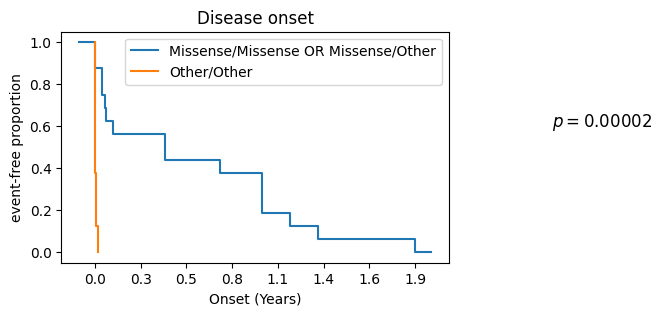

In [14]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

missense_onset_fig, ax = plt.subplots(figsize=(5, 3))
missense_onset_result.plot_kaplan_meier_curves(ax=ax)
def days_to_years(x, pos):
    return f"{x / 365.25:.1f}"


ax.xaxis.set_major_formatter(FuncFormatter(days_to_years))
ax.set_xlabel("Onset (Years)")
ax.set_ylabel("event-free proportion")
ax.set_title("Disease onset")
s = f"p={missense_onset_result.pval:.5f}"
ax.text(x=1000, y=0.6, s=f"${s}$", fontsize=12)

In [15]:
homodimerization_onset_result = survival_analysis.compare_genotype_vs_survival(
    cohort=cohort,
    gt_clf=homodimerization_predicate,
    endpoint=endpoint,
)
print(f"survival analysis p={missense_onset_result.pval:.5e}")

survival analysis p=1.65817e-05


Text(1000, 0.6, '$p=0.25183$')

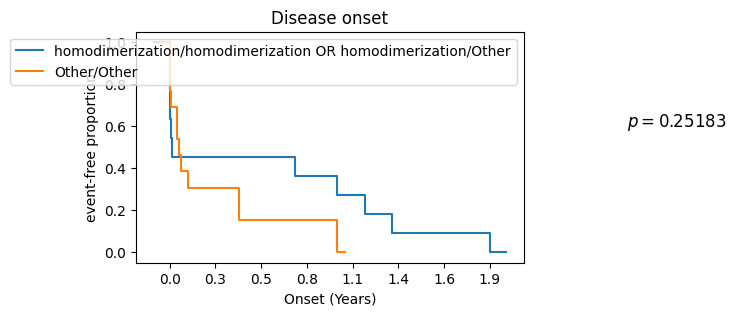

In [16]:
hd_onset_fig, ax = plt.subplots(figsize=(5, 3))
homodimerization_onset_result.plot_kaplan_meier_curves(ax=ax)
def days_to_years(x, pos):
    return f"{x / 365.25:.1f}"


ax.xaxis.set_major_formatter(FuncFormatter(days_to_years))
ax.set_xlabel("Onset (Years)")
ax.set_ylabel("event-free proportion")
ax.set_title("Disease onset")
s = f"p={homodimerization_onset_result.pval:.5f}"
ax.text(x=1000, y=0.6, s=f"${s}$", fontsize=12)

# Summary

In [17]:
from gpseacs.report import  GPAnalysisResultSummary, GpseaAnalysisReport


m_results = (
    GPAnalysisResultSummary.from_mono(
        result=missense_onset_result
    ),
    GPAnalysisResultSummary.from_mono(
        result=homodimerization_onset_result
    ),
    
)

f_results =  (
    GPAnalysisResultSummary.from_multi(
        result=homodimerization_result,
    ), 
    GPAnalysisResultSummary.from_multi(
        result=missense_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result=moco_result,
    ), 
)

report = GpseaAnalysisReport(
    name=gene_symbol,
    cohort=cohort,
    mono_results=m_results,
    fet_results=f_results,
    gene_symbol=gene_symbol,
    mane_tx_id=mane_tx_id,
    mane_protein_id=mane_protein_id,
)

In [18]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

In [ ]:
# summarizer.process_latex(report=report, protein_fig=suox_fig, stats_fig=missense_onset_fig)